In [1]:
"""
Simple setup to compute the normalized flow generative model
"""

import lightning.pytorch as pl
import torch

# import datasrt class
from torch.utils.data import DataLoader

In [2]:
# first we need to generate some simple datasets
def generate_data(nb_cluster_1, nb_cluster_2, nb_samples):
    """
    This function generate 2 dataset :
    - nb_cluster_1 cluster of gaussian
    - nb_cluster_2 cluster of gaussian

    Args:
        nb_cluster_1: number of cluster in the first dataset
        nb_cluster_2: number of cluster in the second dataset
        nb_samples: number of samples in the dataset

    """
    # set seed
    torch.manual_seed(42)

    # first we generate the random position of the cluster
    cluster_1 = torch.distributions.MultivariateNormal(
        torch.zeros(2), torch.eye(2)
    ).sample((nb_cluster_1,))

    cluster_2 = torch.distributions.MultivariateNormal(
        torch.zeros(2), torch.eye(2)
    ).sample((nb_cluster_2,))

    # then we generate the data
    data_1 = torch.distributions.MultivariateNormal(
        cluster_1, torch.eye(2) / 100.0
    ).sample((nb_samples,)) - 1.

    data_2 = torch.distributions.MultivariateNormal(
        cluster_2, torch.eye(2) / 100.0
    ).sample((nb_samples,)) + 1.

    return data_1, data_2


data_1, data_2 = generate_data(4, 4, 10000)

In [10]:
# now we want to create a simple neural network that represent the probability flow u(t, x)

import torch.nn as nn
import torch.nn.functional as F
import ot


class Net(pl.LightningModule):
    def __init__(self):
        super(Net, self).__init__()

        self.sigma = 0.002

        self.fc1 = nn.Linear(3, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc5 = nn.Linear(100, 2)

        # init weights
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        torch.nn.init.xavier_uniform_(self.fc5.weight)

    def forward(self, x, t):
        x = torch.cat((x, t), 1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc5(x)
        return x

    def training_step(self, batch, batch_idx):
        # first we take a look at the batch information
        data_0, data_1 = batch

        with torch.no_grad():
            size_batch = data_0.size(0)

            # now we want to reorder the data
            # applying optimal transport method
            distance_matrix = ot.dist(data_0, data_1)

            weight1, weight2 = (
                torch.ones((size_batch,)) / size_batch,
                torch.ones((size_batch,)) / size_batch,
            )  # uniform distribution on samples

            # convert the weight to device
            weight1 = weight1.to(distance_matrix.device)
            weight2 = weight2.to(distance_matrix.device)


            # transport plan p
            transport_plan = ot.emd(
                weight1, weight2, distance_matrix
            ) * size_batch

            # then we apply the transport plan
            # data_0 = torch.matmul(transport_plan, data_0)
            data_1 = torch.matmul(transport_plan, data_1)
            
            data_1 = data_1.detach()
            data_0 = data_0.detach()

        batch_size = data_1.size(0)

        # we generate the time between 0 and 1
        t = torch.rand(batch_size, 1).to(data_0.device)

        mean_sample = t * data_1 + (1 - t) * data_0
        sigma = self.sigma

        # we generate the noise
        noise = torch.randn_like(mean_sample) * sigma + mean_sample

        target = data_1 - data_0

        # then we compute the loss
        loss = F.mse_loss(self(noise, t), target)

        self.log("train_loss", loss)

        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def generate(self, x_0):
        nb_step = 50
        # 50 t value between 0 and 1
        t = torch.linspace(0, 1, nb_step).unsqueeze(0).to(x_0.device)

        batch = x_0.shape[0]

        t = t.repeat(batch, 1)

        # register the intermediate tensor
        register = []

        for step in range(nb_step):
            t_i = t[:, [step]]
            x_0 = x_0 + self(x_0, t_i) * 1.0 / nb_step
            register.append(x_0.detach().cpu())

        return x_0, register


# create the model
model = Net()

# flatten data_1 and data_2 to be of shape batch_size x 2
data_1 = data_1.view(-1, 2)
data_2 = data_2.view(-1, 2)


# create dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_1, data_2):
        self.data_1 = data_1
        self.data_2 = data_2

    def __len__(self):
        return self.data_1.shape[0]

    def __getitem__(self, idx):
        # we randomly select one element from each dataset
        # data_1 and data_2
        idx_1 = torch.randint(0, self.data_1.shape[0], (1,))[0]

        idx_2 = torch.randint(0, self.data_2.shape[0], (1,))[0]

        return self.data_1[idx_1], self.data_2[idx_2]


dataset = Dataset(data_1, data_2)

# create dataloader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# wandb logger
logger = pl.loggers.WandbLogger(project="normalizeflow")

# create trainer
trainer = pl.Trainer(max_epochs=100, logger=logger, accumulate_grad_batches=8)
trainer.fit(model, dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:391: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory ./normalizeflow/m4j4e62k/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params
--------------------------------
0 | fc1  | Linear | 400   
1 | fc2  | Linear | 10.1 K
2 | fc5  | Linear | 202   
--------------------------------
10.7 K    Trainable params
0         Non-trainable params
10.7 K    Total params
0.043     Total estimated model params size (MB)
/h

Training: |          | 0/? [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
data_1.shape

torch.Size([50000, 2])

In [11]:
# sample 100 points for the 30000 points
size_batch = 100
index_random = torch.randperm(data_2.shape[0])[:size_batch]
data_1_sample = data_1[index_random]
data_2_sample = data_2[index_random]

In [12]:
size_batch = data_2_sample.size(0)

# now we want to reorder the data
# applying optimal transport method
distance_matrix = ot.dist(data_1_sample, data_2_sample)

weight1, weight2 = (
    torch.ones((size_batch,)) / size_batch,
    torch.ones((size_batch,)) / size_batch,
)  # uniform distribution on samples

# transport plan p
transport_plan = ot.emd(
    weight1, weight2, distance_matrix
) * size_batch

# then we apply the transport plan
# data_1_sample = torch.matmul(transport_plan, data_1_sample)
data_2_sample = torch.matmul(transport_plan, data_2_sample)

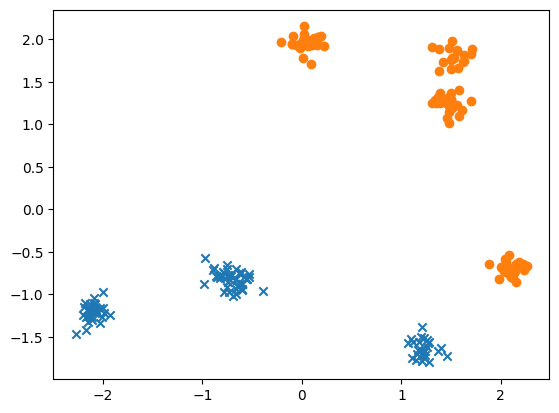

In [13]:
# plot sample
import matplotlib.pyplot as plt

plt.scatter(data_1_sample[:, 0], data_1_sample[:, 1], marker="x")
plt.scatter(data_2_sample[:, 0], data_2_sample[:, 1], marker="o")

In [14]:
final_data, register = model.generate(data_1_sample.to(model.device))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


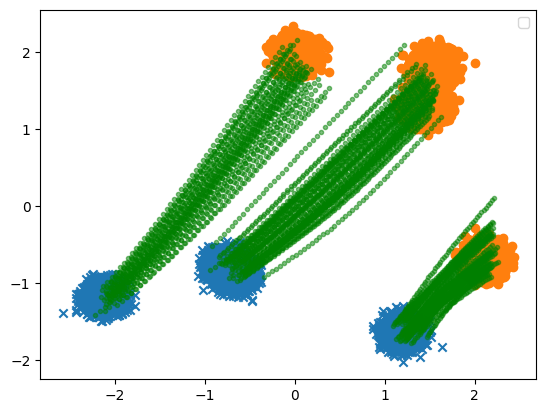

In [15]:
# now we want to plot the data
import matplotlib.pyplot as plt

size_plot_point = 10000

plt.scatter(data_1[:size_plot_point, 0], data_1[:size_plot_point, 1], marker="x")
plt.scatter(data_2[:size_plot_point, 0], data_2[:size_plot_point, 1], marker="o")

# now we want to plot the trajectory
for i in range(len(register)):
    plt.scatter(
        register[i][:, 0], register[i][:, 1], marker=".", alpha=0.5, color="green"
    )

plt.legend()

plt.show()